### In this notebook we plot the full maps we get of Blank and Sample in the InVia, and count the number of fluorescence events. We first convert the map into a binary map, and then apply different algorithms to count the points (events). Originally we were using the simple Kmeans algorithm but it is not good to count single events. We adopt a customized clustering that seems to do a good job. This is explained in one of my reports. 

### Import packages and data

In [521]:
#IMPORT PACKAGES:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms

%pylab inline
import numpy as np
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from scipy.sparse.linalg import spsolve

folder = "C:/Users/gfonseca/OneDrive - MEDCOM ADVANCE, S.A/Escritorio/MEASUREMENTS/20210721/Full Blank/Maps/"
map_file = 'FULL BLANK_SigToAx_map.txt'
data = pd.read_csv(folder+map_file, sep="\t")

Populating the interactive namespace from numpy and matplotlib


In [522]:
data.columns = ["x", "y",'Sim']
data = data.replace('-nan(ind)',0) #replace any weird "-nan(ind)" string (sometimes there are) with a zero

data['Sim'] = np.where(data.Sim < 4580, 0, data.Sim) #Replace any negative value with zero to have 0 has the lower limit (this 
#is especially for Signal To axis maps where you can have a negative lower limit), or put a threshold that you want, to filter 
#by intensity

data['Sim'] = data.Sim.astype(float)
data['Sim'] = (data['Sim']-data['Sim'].min())/(data['Sim'].max()-data['Sim'].min()) #Normalize to 1
data

,x,y,Sim
0,19648.800781,14885.000000,0.0
1,19648.800781,14861.599609,0.0
2,19648.800781,14838.200195,0.0
3,19648.800781,14814.799805,0.0
4,19648.800781,14791.400391,0.0
...,...,...,...
93065,24937.199219,5408.000000,0.0
93066,24937.199219,5384.600098,0.0
93067,24937.199219,5361.200195,0.0
93068,24937.199219,5337.799805,0.0


In [523]:
#How many points (spectra) are left
len(data[data['Sim']>0])

387

### Plot a map of the data

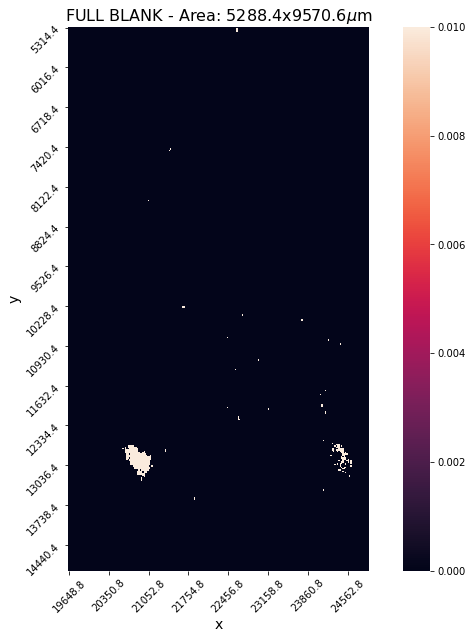

In [524]:
#CREATE THE 2D ARRAY FROM THE DATAFRAME COLUMNS
mappa = data.round(decimals=10).pivot('y', 'x', 'Sim')

fig, ax1 = plt.subplots(figsize=(12, 10))
im=sns.heatmap(mappa, vmin= 0, vmax=0.01, square=True, xticklabels=30, yticklabels=30, cbar=True,cbar_kws={"shrink": 1})
plt.title('FULL BLANK - Area: '+ str(round(data['x'].max()-data['x'].min(),2))+'x'+ 
              str(round(data['y'].max()-data['y'].min(),2))+'$ \mu$m',fontsize=16)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
labelsX = [item.get_text() for item in im.get_xticklabels()]
labelsY = [item.get_text() for item in im.get_yticklabels()]
im.set_xticklabels([str(round(float(label), 2)) for label in labelsX])
im.set_yticklabels([str(round(float(label), 2)) for label in labelsY])
plt.xticks(rotation=45)
plt.yticks(rotation=45);
 
savefig(folder +'ExampleSigToAxfilt.png', dpi=None, facecolor='w', edgecolor='w',orientation='portrait', format=None,
transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None);

### Trasform the data into a scattered map

Total number of points: 387


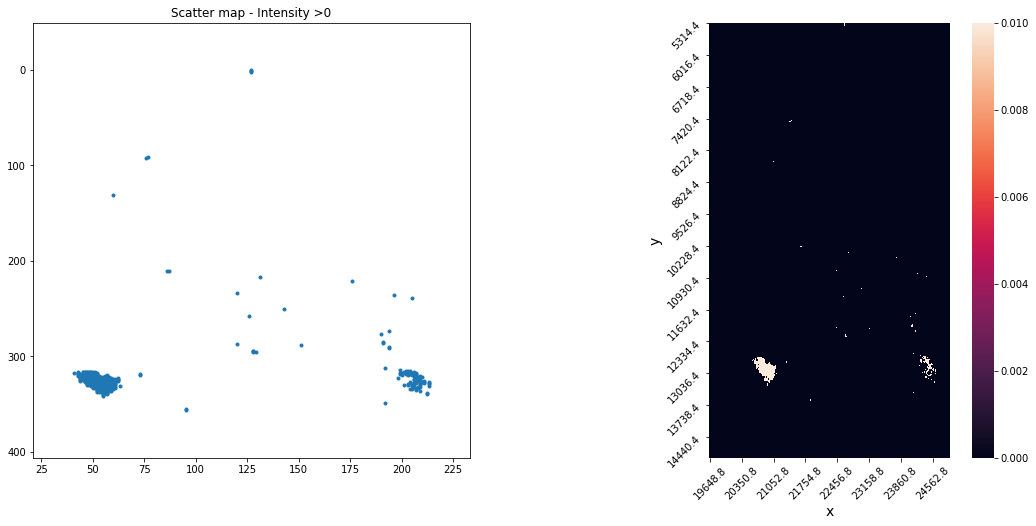

In [525]:
Threshold = 0
sim_map_binario = mappa > Threshold #Gives a map with True if values>Threshold and False otherwise. In the second cell above you
#can already filter by intensity, in which case here you don't wanna do it again (so keep Threshold = 0 here)
sim_map_binario = sim_map_binario.to_numpy()
     
vector_x = [] #The pixel map is transformed to a scatter map, where every event is a point
vector_y = []
    
for i in np.arange(sim_map_binario.shape[0]):
     for j in np.arange(sim_map_binario.shape[1]):
        if sim_map_binario[i,j] == 1:
            vector_x.append(i)
            vector_y.append(j)
        
XX = np.array([vector_x, vector_y]).T

#PLOT THE NEW ARRAY XX, TO VISUALIZE THE SCATTER MAP WHERE EVERY EVENT IS A POINT, LIKE DEFINED ABOVE. LITTLE TRICK IS USED TO 
#PLOT IT WITH SAME ORIENTATION AS THE ORIGINAL MAP (BASICALLY THE AXES ARE SWAPPED AND THE VERTICAL ONE IS REVERSED).

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 8))
plt.subplots_adjust(wspace=0.3)

im=sns.heatmap(mappa, vmin= 0, vmax=0.01,square=True, xticklabels=30, yticklabels=30, cbar=True,cbar_kws={"shrink": 1})
ax1.set_title('FULL BLANK - Area: '+ str(round(data['x'].max()-data['x'].min(),2))+'x'+ 
              str(round(data['y'].max()-data['y'].min(),2))+'$ \mu$m',fontsize=16)
ax2.set_xlabel('x',fontsize=14)
ax2.set_ylabel('y',fontsize=14)
labelsX = [item.get_text() for item in im.get_xticklabels()]
labelsY = [item.get_text() for item in im.get_yticklabels()]
ax2.set_xticklabels([str(round(float(label), 2)) for label in labelsX])
ax2.set_yticklabels([str(round(float(label), 2)) for label in labelsY])
plt.xticks(rotation=45)
plt.yticks(rotation=45);

ax1.plot(XX[:,1], XX[:,0],marker='.',linestyle='None')
ax1.set_ylim(max(XX[:,0]+50), min(XX[:,0]-50))
ax1.set_xlim(min(XX[:,1]-20), max(XX[:,1]+20))
ax1.set_title('Scatter map - Intensity >'+ str(Threshold)+'')
#ax1.set_xlim(5,250);
#plt.ylim(40,60)

print('Total number of points:',len(XX))

Number of points: 387


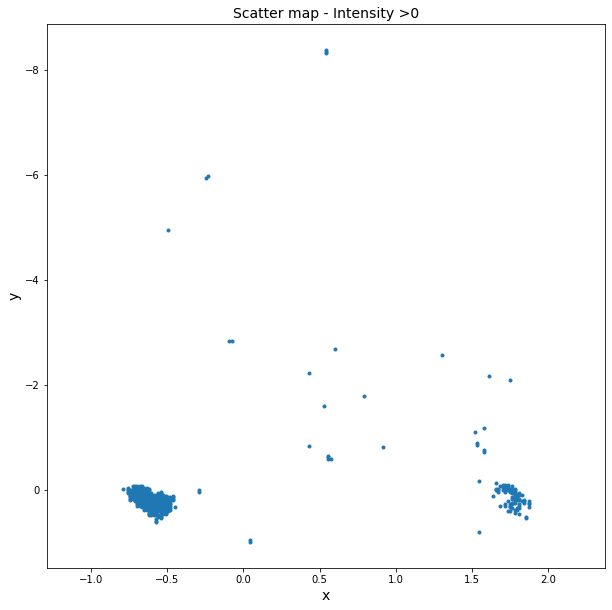

In [526]:
#Standardize the data to make it go from 0 to 1 (important to do it for Kmeans, not so much for the customized clustering), and
#plot again the binary map (Uuncomment the last two lines to save the binary map as an image)

scaler = StandardScaler()
XX1 = scaler.fit_transform(XX)

plt.figure(figsize=(10,10))
plt.plot(XX1[:,1], XX1[:,0],marker='.',linestyle='None')
#plt.ylim(max(XX1[:,0]+0.2), min(XX1[:,0]-0.2))
plt.ylim(max(XX1[:,0]+0.5), min(XX1[:,0]-0.5))
plt.xlim(min(XX1[:,1]-0.5), max(XX1[:,1]+0.5))
plt.title('Scatter map - Intensity >'+ str(Threshold), fontsize = 14)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
#plt.ylim(2,1.8)
print('Number of points:', len(XX1))

savefig(folder +'ScatterExampleSigToAxfilt.png', dpi=None, facecolor='w', edgecolor='w',orientation='portrait', format=None,
transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None);

## Use the full file with all the spectra for filtering

#### This is an alternative to filtering by intensity, where we filter by spectra. To do that we need the full Wire file, saved as txt, which contains all the spectra one after the other, resulting in millons of rows.. This is slow to import and play with. Anyway, if you wanna go for this, you don't need the maps above, you only need the "data" dataframe at some point later.

In [251]:
#IMPORT THE FULL FILE (this can take a while..)
FULL = 'full blank.txt'
dataFull = pd.read_csv(folder+FULL, sep="\t")
dataFull.columns = ["x", "y", "RamanShift","Counts","Nada1","Nada2","Nada3"]
dataFull['x']=dataFull.x.astype(float)
dataFull.Counts = dataFull.Counts.fillna(0)
dataFull=dataFull.dropna(1)
dataFull.head(5)

,x,y,RamanShift,Counts
0,255.300003,6922.899902,597.683167,9.887068
1,255.300003,6922.899902,597.628967,21.421980
2,255.300003,6922.899902,597.574768,4.942479
3,255.300003,6922.899902,597.520569,-1.647141
4,255.300003,6922.899902,597.466370,-3.293580


In [42]:
#import gc
#gc.collect()

In [320]:
#FIRST, LET'S KEEP ONLY VALUES BELOW 570nm (it's enough to recognize the fluorescence)
dataFull1 = dataFull[(dataFull['RamanShift']<=570)]

In [321]:
#SEPARATE THE DIFFERENT SPECTRA BY SPLITTING THE "dataFull" DATAFRAME INTO A NUMBER NumSp OF DATAFRAMES.
#NumSp is the total number of spectra taken during the streamline measurement, and can be taken from the "collected data" section 
#of the Navigator in Wire. 

NumSp = 144384
ListSpec = np.array_split(dataFull1, NumSp)

In [322]:
#FIRST FILTERING: Only keep spectra with mean higher than a value "FilterCosmic" (this gets rid of cosmic rays spectra mainly)
FilterCosmic = 100
ListSpec1 = list(filter(lambda x: x['Counts'].mean()>FilterCosmic, ListSpec))

In [323]:
#Spectra left
len(ListSpec1)

927

In [324]:
#SECOND FILTERING: KEEP ONLY THOSE SPECTRA WHOSE Counts MAXIMUM VALUE IS HIGHER THAN A VALUE "FilterCounts" (this gets rid of
#low spectra)
FilterCounts = 250
ListSpec2 = list(filter(lambda x: x['Counts'].max()>FilterCounts, ListSpec1))

In [325]:
#Spectra left
len(ListSpec2)

338

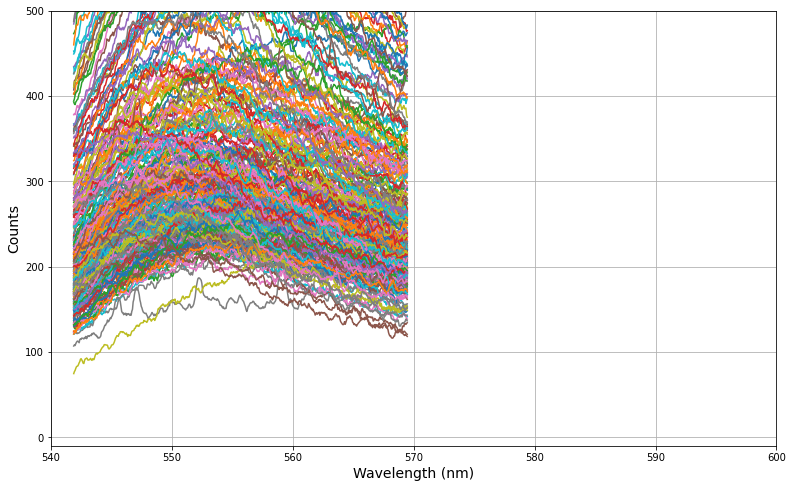

In [326]:
#PLOT THE SPECTRA LEFT AFTER THE FILTERING

list_x=[]
list_y=[]
headers=[]
for counts,i in enumerate(ListSpec2):
    list_x.append(i.RamanShift.reset_index(drop=True))
    list_y.append(i.Counts.reset_index(drop=True))
    headers.append(counts)
    
data_x = pd.concat(list_x,axis=1, keys=headers)
data_y = pd.concat(list_y, axis=1, keys=headers)*factor/(integration_time)

data_y = data_y.rolling(10).mean()


fig = plt.figure(figsize=(13, 8)) 
plt.plot(data_x[0],data_y);
plt.margins(x=0)
plt.grid()
plt.ylim(-10,500)
plt.xlabel('Wavelength (nm)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
#plt.title(str(map_file)+' - Spectra [BS-subtracted]',fontsize=14)
plt.xlim(540,600);

#savefig(folder +'Selected Spectra.png', dpi=None, facecolor='w', edgecolor='w',orientation='portrait', format=None,
#transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None);

In [330]:
#JOINING EACH SPECTRA WITH THE data DATAFRAME BY COORDINATES, TO RETRIEVE THE CORRESPONDING Sim VALUE FOR EACH, AND CREATE A 
#NEW DATAFRAME WITH THOSE
MESCLA = []
for spec in ListSpec2:
    MESCLA.append(pd.merge(spec, data, how='inner').iloc[[0]].drop(['RamanShift', 'Counts'], axis=1))

In [331]:
MESCLA1 = pd.concat(MESCLA, axis=0, ignore_index=True)

In [332]:
MESCLA1 #This are now only the map points corresponding to the selected spectra

,x,y,Sim
0,664.799988,1638.400024,0.045542
1,664.799988,1618.900024,0.038875
2,664.799988,1599.400024,0.037817
3,684.299988,1638.400024,0.042979
4,684.299988,838.900024,0.040188
...,...,...,...
333,7548.299805,4212.399902,0.052474
334,7548.299805,4192.899902,0.050793
335,7548.299805,4173.399902,0.033406
336,7567.799805,4212.399902,0.043440


In [333]:
#PUT ALL VALUES THAT DON'T CORRESPOND TO THE SELECTED SPECTRA TO ZERO IN THE data DATAFRAME, TO MAKE A NEW COPLETE MAP
data['SimNew'] = np.where(~data.Sim.isin(MESCLA1.Sim), 0, data.Sim )

In [334]:
data

,x,y,Sim,SimNew
0,255.300003,6922.899902,0.000573,0.0
1,255.300003,6903.399902,0.000517,0.0
2,255.300003,6883.899902,0.000498,0.0
3,255.300003,6864.399902,0.000571,0.0
4,255.300003,6844.899902,0.000455,0.0
...,...,...,...,...
144379,7723.799805,-311.600006,0.000000,0.0
144380,7723.799805,-331.100006,0.000000,0.0
144381,7723.799805,-350.600006,0.000000,0.0
144382,7723.799805,-370.100006,0.000000,0.0


In [462]:
# MAKE THE MAP AGAIN AFTER FILTERING BY SPECTRA
mappa = data.round(decimals=10).pivot('y', 'x', 'SimNew')

sim_map_binario = mappa > 0 #Gives a map with True if values>0 and False otherwhise
sim_map_binario = sim_map_binario.to_numpy()
     
#The pixel map is transformed to a scatter map, where every event is a point
vector_x = []
vector_y = []
    
for i in np.arange(sim_map_binario.shape[0]):
     for j in np.arange(sim_map_binario.shape[1]):
        if sim_map_binario[i,j] == 1:
            vector_x.append(i)
            vector_y.append(j)
        
XX = np.array([vector_x, vector_y]).T

#PLOT THE NEW ARRAY XX, TO VISUALIZE THE SCATTER MAP WHERE EVERY EVENT IS A POINT, LIKE DEFINED ABOVE. LITTLE TRICK IS USED TO 
#PLOT IT WITH SAME ORIENTATION AS THE ORIGINAL MAP TO THE LEFT (BASICALLY THE AXES ARE SWAPPED AND THE VERTICAL ONE IS REVERSED).

scaler = StandardScaler() #STANDARDIZE THE DATA TO HAVE IT READY FOR CLUSTERING LATER
XX1 = scaler.fit_transform(XX)

plt.figure(figsize=(10,10))
plt.plot(XX1[:,1], XX1[:,0],marker='.',linestyle='None')
#plt.ylim(max(XX1[:,0]+0.2), min(XX1[:,0]-0.2))
plt.ylim(max(XX1[:,0]+1), min(XX1[:,0]-1))
plt.xlim(min(XX1[:,1]-0.5), max(XX1[:,1]+0.5))
plt.title('Scatter map - Intensity >'+ str(Threshold), fontsize = 14)
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
#plt.ylim(2,1.8)
print('Number of points:', len(XX1))
#savefig(folder +'Scatter map threshold 0.25.png', dpi=None, facecolor='w', edgecolor='w',orientation='portrait', format=None,
#transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None);

KeyError: 'SimNew'

## Customized clustering method

In [475]:
#Transform XX1 into a dataframe
XX1_df = pd.DataFrame(XX1, columns = ['y','x'])

In [476]:
#Use KDTree to find the points that are close to each other within a radius "dist"
from scipy.spatial import KDTree

dist = 0.1
points_tree = KDTree(XX1)
points_in_radius = points_tree.query_pairs(dist)
A = list(points_in_radius) #Shows all the pairs of points (the indices in XX1) found with KDTree

l = []; l1=[]; lsec=[]
for row in A:
    l1.extend(row)   # make a simple list with all the numbers in A
    l.append(row[0]) # make a list with the 1st elements of the pairs in A
    lsec.append(row[1]) # make a list with the 2nd elements of the pairs in A
    
l = [x for x in l if x not in lsec] #remove values in l that are also in lsec (because if a value appearing as the first element
# of the pair also appears as the second element of another pair we don't take it, since l already contains the first element
# of that other pair; and it would be a repetition)
    
l = list(dict.fromkeys(l)) #Getting rid of duplicates
l1 = list(dict.fromkeys(l1))
#l = sorted(l) #From smaller to higher
#l1 = sorted(l1)
print('Pair of points that are close to one another \033[1mA\033[0m:', A)
print('Sorted points in A, without repetitions \033[1ml1\033[0m:', l1)
print('First elements of the A pairs, without repetitions \033[1ml\033[0m:', l)

#l3=[l[0]] #initialize new list with the first element of l2 to make sure it's included
#[l3.append(i) for k,i in enumerate(l) if l[k]-l[k-1]>1] #Put in l3 all the elements of l2 whose distance to prev one > 1
#print('Only the isolated points \033[1ml3\033[0m:', l3)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [477]:
XX2 = XX1_df[XX1_df.index.isin(l1)] #Filter XX1 with only the points indicated in l1
XX1_isolated = XX1_df[XX1_df.index.isin(l1)==False] #Filter XX1 with only the points NOT indicated in L1
XX1_isolated = np.array(XX1_isolated)
XX3 = XX1_df[XX1_df.index.isin(l)] #Filter XX1 with only the points indicated in l
XX4 = XX2.to_numpy() #Convert to numpy for plotting
XX5 = XX3.to_numpy()

In [478]:
#XX1_isolated = [i for i in XX1 if i not in XX4] #Original XX1 array minus the points in XX4
#XX1_isolated = np.array(XX1_isolated) #Conversion to properly plot it

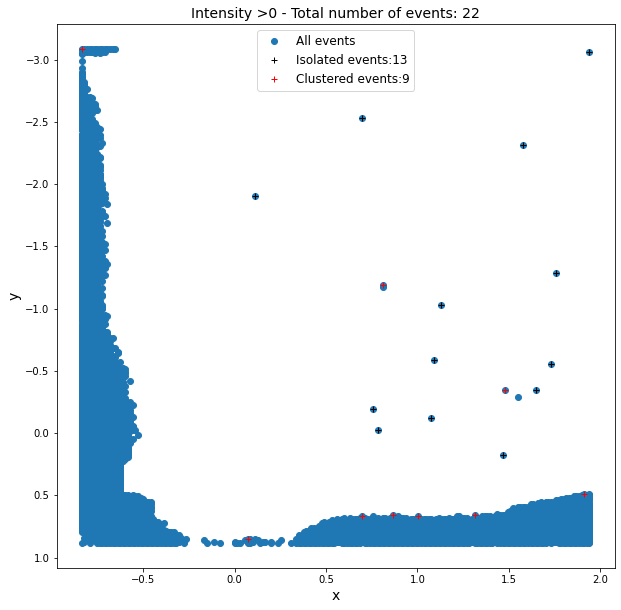

In [479]:
plt.figure(figsize=(10,10))
plt.plot(XX1[:,1], XX1[:,0],marker='o',linestyle='None',label='All events')
plt.plot(XX1_isolated[:,1], XX1_isolated[:,0],marker='+',c='k',linestyle='None',label='Isolated events:'+ str(len(XX1_isolated)))
plt.plot(XX5[:,1], XX5[:,0],marker='+',c='r',linestyle='None', label='Clustered events:'+ str(len(XX5)))
plt.ylim(max(XX1[:,0]+0.2), min(XX1[:,0]-0.2))
plt.title('Intensity >'+ str(Threshold)+' - Total number of events: '+ str(len(XX1_isolated)+len(XX5)),fontsize=14);
plt.xlabel('x',fontsize=14)
plt.ylabel('y',fontsize=14)
plt.legend(fontsize=12)

#savefig(folder +'Customized Clustering.png', dpi=None, facecolor='w', edgecolor='w',orientation='portrait', format=None,
#transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None);

In [195]:
#Way to explicitely calculate the euclidean distance between the XX1 points 

'''from scipy.spatial import distance
EUCLIDE = distance.cdist(XX1, XX1, 'euclidean').flatten()
EUCLIDE_df = pd.DataFrame(EULIST, columns = ['Distance'])
EUCLIDE_df = EUCLIDE_df[EUCLIDE_df['Distance']>0]
EUCLIDE_df = EUCLIDE_df.drop_duplicates().reset_index(drop=True)
EUCLIDE_df''';

## KMeans - first attempt: you guess the number of clusters

Lowest SSE value: 1.4933334501690467
Clusters centers: [[-0.92582755 -0.92333924]
 [-1.67775911 -0.47052311]
 [ 1.51370941  1.36341397]
 [ 0.39457771  1.46912042]
 [ 1.01869319 -0.87873971]
 [-0.67242558  0.7362816 ]
 [ 0.59684678  1.50095079]
 [-0.52581444 -0.2852513 ]
 [-0.40273348 -1.19426753]
 [ 0.64300214 -0.88262597]
 [ 0.40272277 -0.04985459]
 [-1.59059635 -0.44756601]
 [-0.23491932 -1.19426753]
 [ 1.71679299  1.89697985]
 [-1.07297105 -0.52665703]
 [ 0.5737691  -0.93370262]
 [ 0.68466727  1.50772684]
 [ 1.17650379  0.78957897]
 [ 2.43084353 -0.43181906]
 [ 1.69778784  1.89105792]
 [ 0.59820429 -0.89372959]
 [ 1.77109341  0.85953176]
 [-1.83988465 -0.50140174]
 [-1.57652761 -0.27710865]
 [-1.56838254 -0.55075116]
 [ 0.46299624  1.48066818]
 [ 0.5859867  -0.92037828]
 [ 0.71223518 -0.88928815]
 [-0.28689258  1.70747809]
 [-0.5732039   0.65068279]
 [ 0.31964313  1.45401949]
 [ 0.52267734  1.48971258]
 [-1.29688043 -0.77084955]
 [ 0.29194991 -0.71340683]
 [-1.18556457 -0.2008638 ]


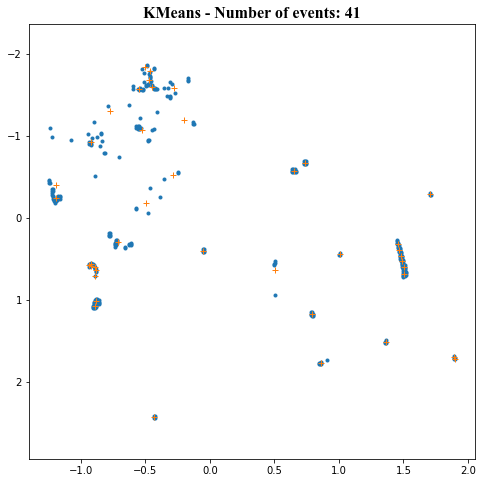

In [343]:
kmeans = KMeans(init="random", n_clusters=41, n_init=10, max_iter=300)
    
kmeans.fit(XX1)

#The lowest SSE value
print('Lowest SSE value:', kmeans.inertia_)

print('Clusters centers:',kmeans.cluster_centers_)

print('Number of iterations:',kmeans.n_iter_)
print('Points labels:', kmeans.labels_)

plt.figure(figsize=(8,8))
plt.plot(XX1[:,1], XX1[:,0],marker='.',linestyle='None')
plt.plot(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0], marker='+',linestyle='None')
plt.ylim(max(XX1[:,0]+0.5), min(XX1[:,0]-0.5))
#plt.ylim(2,1.8)
plt.title('KMeans - Number of events: '+str(len(kmeans.cluster_centers_)),fontweight="bold",fontname="Times New Roman",fontsize=16);

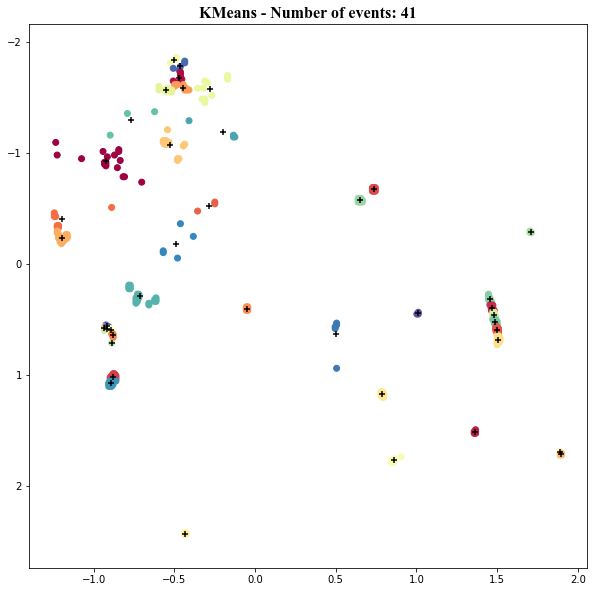

In [344]:
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(kmeans.labels_))))
plt.figure(figsize=(10,10))
plt.scatter(XX1[:,1], XX1[:,0], c = colors[kmeans.labels_])
plt.ylim(max(XX1[:,0]+0.3), min(XX1[:,0]-0.3))
plt.scatter(kmeans.cluster_centers_[:,1],kmeans.cluster_centers_[:,0], marker='+',linestyle='None', c='k')
plt.title('KMeans - Number of events: '+str(len(kmeans.cluster_centers_)),fontweight="bold",fontname="Times New Roman",fontsize=16)

savefig(folder +'Number of events.png', dpi=None, facecolor='w', edgecolor='w',orientation='portrait', format=None,
transparent=False, bbox_inches='tight', pad_inches=0.1,metadata=None);

## KMeans  - second attempt: you give a range for the number of clusters

Number of iterations: 9
Points labels: [ 6  6  6  6  6  6  6  6  6  6 22 18 18 22 18 22 22 18 22 18 22 22 22  3
 22 22  3 22 22  8  8  3  3  3  3 22 22 22 22  3  3  3  8  8  8  8  8 19
 19 39 39 24 21 21 21 39 39 39 13 39 39 39 39 39 39 39 39 39 39 24  7 24
 13  7  7 13 16 16  7 16  7  7  7  7  7  7 10 10 10 28 28 28 28 28 28 28
 28 28 28 28 28 28 28 28 28 17 28 28 28 28 17 10 17 26 26 26 26 17 14 14
 14 14 14 43 14 43 43 27 27 27 27 27 27 25 27 27 27 27 27 27 27 27 27 27
 27 27 27 25 25 25 12 12 12 12 12 12 12 12 23 12 12 23 12 12 12  9 23 23
 12 12  9  9 23 23 12 12  9  9 23 23 12  9 23 23  9 23 23 23 41 41 23 23
 41 41 42 42 41 41 42 42 42 30 42 42 30 30 42 42 42 42 42  4  4  4  4  4
  4  4  4  4  0  4  4  4 11  0  4  4 11 11 11 11  0 34 34 11 11 11  5  5
  0 34 34 34 11  5  5 34 34 34  5 34 34 29 29 34 34 29  2  2 29  2  2  2
  2  2  2  2  2 29  2  2  2 15 40 40 40 40 40 40 35 35 35 35 35 38 38 35
 35 35 38 38 38 38 38 37 37 37 38 37 37 37 37 37 37 37 36 36 36 36 36 33
 33 33 33 33

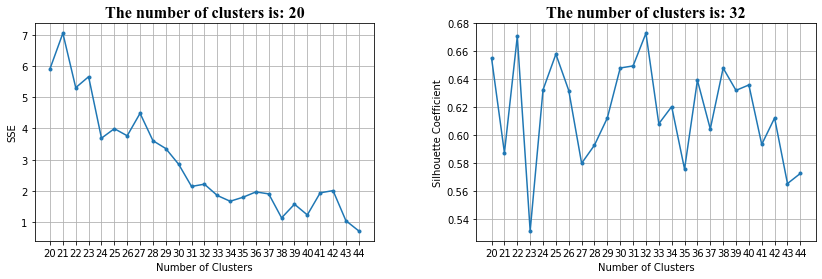

In [345]:
sse = [] #sum of squared errors
silhouette_coefficients = []
R = range(20,45)
num = []

for k in R:
    kmeans = KMeans(init='random',n_clusters=k, n_init=20, max_iter=300)
    kmeans.fit(XX1)
    sse.append(kmeans.inertia_) #for the elbow method
    score = silhouette_score(XX1, kmeans.labels_) #for the silhouette coefficient method
    silhouette_coefficients.append(score)
    num.append(k)
    
from kneed import KneeLocator
kl = KneeLocator(R, sse, curve="convex", direction="decreasing")

print('Number of iterations:',kmeans.n_iter_)
print('Points labels:', kmeans.labels_)


#PLOT THE TWO METHODS
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 4))
plt.subplots_adjust(wspace=0.3)
ax1.plot(R, sse, marker='.')
ax1.set_xticks(range(20, 45,1))
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("SSE")
ax1.set_title('The number of clusters is: ' + str(kl.elbow), fontweight="bold",fontname="Times New Roman",fontsize=16)
ax1.grid()
ax2.plot(R, silhouette_coefficients, marker='.')
ax2.set_xticks(range(20, 45, 1))
ax2.set_xlabel("Number of Clusters")
ax2.set_ylabel("Silhouette Coefficient")
ax2.set_title('The number of clusters is: '+str(argmax(silhouette_coefficients)+num[0]), fontweight="bold",
              fontname="Times New Roman", fontsize=16)
ax2.grid()
#ax2.margins(x=0)
#ax2.set_xlim(2,29)

In [248]:
print(argmax(silhouette_coefficients))
silhouette_coefficients

8


[0.4519972091085145,
 0.5275394266484595,
 0.570941946042235,
 0.5139009001968069,
 0.5377368130409056,
 0.5874565523213464,
 0.5768550657377061,
 0.5910949458849758,
 0.6099172434438614,
 0.5252746753417219,
 0.5452509416223414,
 0.3270282131668324,
 0.35717501875431235,
 0.45758772300031303,
 0.27565723040313506,
 0.35768242395055333,
 0.31766034011083294,
 0.251861094753095,
 0.19751678972497747]

The number of clusters is: 32
The number of clusters is: 32


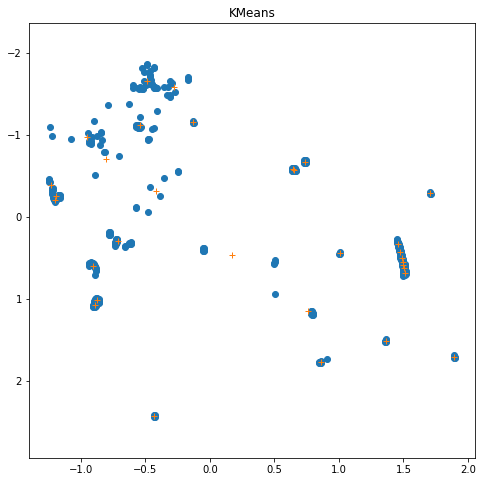

In [346]:
final = KMeans(init="random",n_clusters = argmax(silhouette_coefficients)+num[0],n_init=10, max_iter=300)
final.fit(XX1)
print('The number of clusters is: '+str(argmax(silhouette_coefficients)+num[0]))
print('The number of clusters is: '+str(len(final.cluster_centers_)))

plt.figure(figsize=(8,8))
plt.plot(XX1[:,1], XX1[:,0],marker='o',linestyle='None')
plt.plot(final.cluster_centers_[:,1],final.cluster_centers_[:,0], marker='+',linestyle='None')
plt.ylim(max(XX1[:,0]+0.5), min(XX1[:,0]-0.5))
#plt.ylim(2,1.8)
plt.title('KMeans');

In [250]:
final.labels_

array([9, 9, 9, 2, 2, 2, 2, 2, 2, 5, 4, 1, 5, 1, 1, 0, 0, 3, 3, 8, 8, 8,
       8, 6, 7])

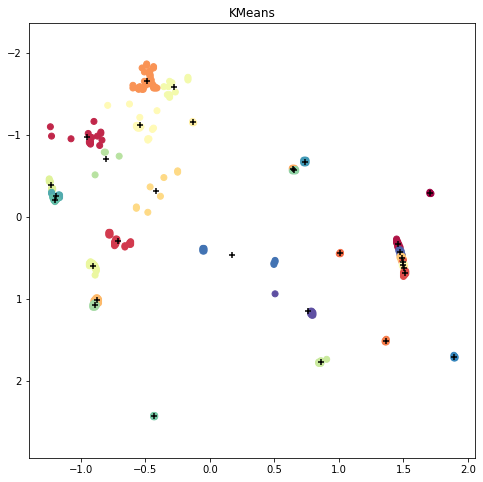

In [347]:
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(final.labels_))))
plt.figure(figsize=(8,8))
plt.scatter(XX1[:,1], XX1[:,0], c = colors[final.labels_])
plt.ylim(max(XX1[:,0]+0.5), min(XX1[:,0]-0.5))
plt.scatter(final.cluster_centers_[:,1],final.cluster_centers_[:,0], marker='+',linestyle='None', c='k')
plt.title('KMeans');